In [5]:
import os
from pathlib import Path

In [6]:
f = os.path.abspath("")

In [13]:
str(Path(os.path.abspath("")).parent.parent)+"/trained_models/hertzian/surrogate_models"

'/home/a11btasa/git_repos/github_imcs/pinns_for_comp_mech/elasticity_2d/trained_models/hertzian/pure/hertzian'

In [ ]:
import deepxde as dde
import numpy as np
import os
from deepxde.backend import tf
from pyevtk.hl import unstructuredGridToVTK
import time
from pathlib import Path
import pandas as pd
import matplotlib.tri as tri

from utils.geometry.custom_geometry import GmshGeometry2D
from utils.geometry.gmsh_models import QuarterDisc
from utils.geometry.geometry_utils import polar_transformation_2d, calculate_boundary_normals

from utils.elasticity.elasticity_utils import problem_parameters, pde_mixed_plane_strain, calculate_traction_mixed_formulation
from utils.elasticity.elasticity_utils import zero_neumann_x_mixed_formulation, zero_neumann_y_mixed_formulation
from utils.contact_mech.contact_utils import zero_tangential_traction
from utils.elasticity import elasticity_utils
from utils.contact_mech import contact_utils

'''
Solves Hertzian normal contact example inluding simulation data from BACI.

@author: tsahin
'''
#dde.config.real.set_float64()

gmsh_options = {"General.Terminal":1, "Mesh.Algorithm": 6}
radius = 1
center = [0,0]

Quarter_Disc = QuarterDisc(radius=radius, center=center, mesh_size=0.025, angle=263, refine_times=100, gmsh_options=gmsh_options)

gmsh_model, x_loc_partition, y_loc_partition = Quarter_Disc.generateGmshModel(visualize_mesh=False)
batch_size = gmsh_model.mesh.getNodes(2, -1, includeBoundary=True)[2].shape[0]//2

revert_curve_list = []
revert_normal_dir_list = [1,2,2,1]
external_dim_size = 5
borders = [-0.2,-1.0]
geom = GmshGeometry2D(gmsh_model,external_dim_size=external_dim_size, borders=borders, revert_curve_list=revert_curve_list, revert_normal_dir_list=revert_normal_dir_list)
print(geom.random_points(1)[:5,:])

# # change global variables in elasticity_utils, they are used for getting the material properties for analytical model
lame = 115.38461538461539
shear = 76.92307692307692
elasticity_utils.lame = lame
elasticity_utils.shear = shear
nu,lame,shear,e_modul = problem_parameters() # with dimensions, will be used for analytical solution
# This will lead to e_modul=200 and nu=0.3

# zero neumann BC functions need the geom variable to be 
elasticity_utils.geom = geom
contact_utils.geom = geom

# how far above the block from ground
distance = 0

# assign local parameters from the current file in contact_utils and elasticity_utils
contact_utils.distance = distance

def calculate_gap_in_normal_direction(x,y,X):
    '''
    Calculates the gap in normal direction
    '''
    # calculate the gap in y direction    
    gap_y = x[:,1:2] + y[:,1:2] + radius + distance

    # calculate the boundary normals
    normals, cond = calculate_boundary_normals(X,geom)

    # Here is the idea to calculate gap_n:
    # gap_n/|n| = gap_y/|ny| --> since n is unit vector |n|=1
    gap_n = tf.math.divide_no_nan(gap_y[cond],tf.math.abs(normals[:,1:2]))
    
    return gap_n

def zero_fischer_burmeister(x,y,X):
    '''
    Enforces KKT conditions using Fischer-Burmeister equation
    '''
    # ref https://www.math.uwaterloo.ca/~ltuncel/publications/corr2007-17.pdf
    Tx, Ty, Pn, Tt = calculate_traction_mixed_formulation(x, y, X)
    gn = calculate_gap_in_normal_direction(x, y, X)
    
    a = gn
    b = -Pn
    
    return a + b - tf.sqrt(tf.maximum(a**2+b**2, 1e-9))

def boundary_circle_not_contact(x, on_boundary):
    return on_boundary and np.isclose(np.linalg.norm(x[:2] - center, axis=-1), radius) and (x[0]<x_loc_partition)

def boundary_circle_contact(x, on_boundary):
    return on_boundary and np.isclose(np.linalg.norm(x[:2] - center, axis=-1), radius) and (x[0]>=x_loc_partition)

# Neumann BC
bc_zero_traction_x = dde.OperatorBC(geom, zero_neumann_x_mixed_formulation, boundary_circle_not_contact)
bc_zero_traction_y = dde.OperatorBC(geom, zero_neumann_y_mixed_formulation, boundary_circle_not_contact)

# Contact BC
bc_zero_fischer_burmeister = dde.OperatorBC(geom, zero_fischer_burmeister, boundary_circle_contact)
bc_zero_tangential_traction = dde.OperatorBC(geom, zero_tangential_traction, boundary_circle_contact)

bcs = [bc_zero_traction_x,bc_zero_traction_y,bc_zero_tangential_traction,bc_zero_fischer_burmeister]


n_dummy = 1
data = dde.data.PDE(
    geom,
    pde_mixed_plane_strain,
    bcs,
    num_domain=n_dummy,
    num_boundary=n_dummy,
    num_test=n_dummy,
    train_distribution = "Sobol"
)

def output_transform(x, y):
    '''
    Hard BCs:
        Dirichlet terms
            u(x=0)=0
        
        Neumann terms:
            sigma_yy(y=0) = ext_traction
            sigma_xy(x=0) = 0
            sigma_xy(y=0) = 0
    
    General formulation to enforce BC hardly:
        N'(x) = g(x) + l(x)*N(x)
    
        where N'(x) is network output before transformation, N(x) is network output after transformation, g(x) Non-homogenous part of the BC and 
            if x is on the boundary
                l(x) = 0 
            else
                l(x) < 0
    
    For instance sigma_yy(y=0) = -ext_traction
        N'(x) = N(x) = sigma_yy
        g(x) = ext_traction
        l(x) = -y
    so
        u' = g(x) + l(x)*N(x)
        sigma_yy = ext_traction + -y*sigma_yy
    '''
    u = y[:, 0:1]
    v = y[:, 1:2]
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    x_loc = x[:, 0:1]
    y_loc = x[:, 1:2]
    ext_traction = x[:, 2:3]
    
    #return tf.concat([u*(-x_loc), ext_dips + v*(-y_loc), sigma_xx, sigma_yy, sigma_xy*(x_loc)*(y_loc)], axis=1)
    return tf.concat([u*(-x_loc)/e_modul, v/e_modul, sigma_xx, ext_traction + sigma_yy*(-y_loc),sigma_xy*(x_loc)*(y_loc)], axis=1)

# 2 inputs: x and y, 5 outputs: ux, uy, sigma_xx, sigma_yy and sigma_xy
layer_size = [3] + [75] * 8 + [5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
net.apply_output_transform(output_transform)

# weights due to PDE
w_pde_1,w_pde_2,w_pde_3,w_pde_4,w_pde_5 = 1e0,1e0,1e0,1e0,1e0
# weights due to Neumann BC
w_zero_traction_x, w_zero_traction_y = 1e0,1e0
# weights due to Contact BC
w_zero_tangential_traction = 1e0
w_zero_fischer_burmeister = 1e4
# weights due to external data
w_ext_u, w_ext_v, w_ext_sigma_xx, w_ext_sigma_yy, w_ext_sigma_xy = 1e4,1e4,1e-1,1e-1,1e-1

loss_weights = [w_pde_1,w_pde_2,w_pde_3,w_pde_4,w_pde_5,w_zero_traction_x,w_zero_traction_y,w_zero_tangential_traction,w_zero_fischer_burmeister]

model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss_weights=loss_weights)

# number epochs required for restoring model
case = "case_1"
case_name_dict = {"case_1": "case_k_1/surrogate_random_p", 
                  "case_2": "case_k_5/surrogate_random_p"}

model_path_parent = str(Path(os.path.abspath("")).parent.parent)+"/trained_models/hertzian/surrogate_models"
model_path = model_path_parent + f"/{case_name_dict[case]}"

n_epoch_dict = {"case_1": 8179,
                "case_2": 11785}

n_epochs = n_epoch_dict[case] # trained model has 3106 iterations
model_restore_path = model_path + "-"+ str(n_epochs) + ".ckpt"

model.compile("adam", lr=0.001)
model.restore(save_path=model_restore_path)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


2023-08-11 15:58:55.924197: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-11 15:58:55.924223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: umay
2023-08-11 15:58:55.924228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: umay
2023-08-11 15:58:55.924288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.199.2
2023-08-11 15:58:55.924307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.199.2
2023-08-11 15:58:55.924313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.199.2



Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)


Info    : Done meshing 1D (Wall 0.195047s, CPU 0.20229s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.109642s, CPU 0.108941s)
Info    : 3689 nodes 7380 elements
Check the plot normal directions.png in /home/a11btasa/pinnswithdxde/paper_results/post-processing-hertz/case_d_final
At location [0. 0.] for node 1, two normals exist such as [0. 1.] and [ 1. -0.]
At location [0. 0.] for node 1 corrected normal is: [0. 1.]


At location [-1.  0.] for node 2, two normals exist such as [0. 1.] and [-1.00000000e+00 -7.66398718e-09]
At location [-1.  0.] for node 2 corrected normal is: [-1.00000000e+00 -7.66398718e-09]


At location [ 0. -1.] for node 3, two normals exist such as [ 1. -0.] and [ 0. -1.]
At location [ 0. -1.] for node 3 corrected normal is: [ 0. -1.]


At location [-0.12186934 -0.99254615] for node 4, two normals exist such as [-0.12186935 -0.99254615] and [-0.12186931 -0.99254616]
At location [-0.12186934 -0.992546

/home/a11btasa/git_repos/deepxde/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/a11btasa/opt/deepxde_venv/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2023-08-11 15:58:58.812687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 6.052443 s

Compiling model...
'compile' took 5.694127 s

INFO:tensorflow:Restoring parameters from /home/a11btasa/pinnswithdxde/paper_results/post-processing-hertz/case_d_final/surrogate_4_random_repeated/surrogate_random_p_3-11785.ckpt


In [2]:
###################################################################################
############################## VISUALIZATION PARTS ################################
###################################################################################
scatter_plot = False
if scatter_plot:
    fem_path = "/home/a11btasa/pinnswithdxde/elasticity_2d/Hertzian_fem/Hertzian_fem_fine_mesh.csv"
    df = pd.read_csv(fem_path)
    node_coords_xy = df[["Points_0","Points_1"]].to_numpy()
else:
    radius = 1
    center = [0,0]
    theta = np.linspace(0, 2 * np.pi, num=15000, endpoint=False)
    X = np.vstack((np.cos(theta), np.sin(theta))).T
    node_coords_xy = radius*X + center

borders=[-0.45,-1.5]
external_dim_size = 3
p_applied = np.linspace(borders[0],borders[1],external_dim_size).reshape(-1,1).astype(np.dtype('f8'))

In [3]:
R = radius
p = abs(p_applied)
e_modul = 200
nu = 0.3

b = 2*np.sqrt(2*R**2*p*(1-nu**2)/(e_modul*np.pi))
n = 50
pc = []
x = []

# calculate analytical solution pc
for i, p_ in enumerate(p):
    x.append(np.linspace(0,b[i],50))
    pc.append(4*R*p[i]/(np.pi*b[i]**2)*np.sqrt(b[i]**2-x[i]**2))

x_loc = []
pc_pred_list = []

# calculate pc pinn
def f_pc_pinn(model, points):
    output = model.predict(points)
    u_pred, v_pred = output[:,0], output[:,1]
    sigma_xx_pred, sigma_yy_pred, sigma_xy_pred = output[:,2:3], output[:,3:4], output[:,4:5]
    sigma_rr_pred, sigma_theta_pred, sigma_rtheta_pred = polar_transformation_2d(sigma_xx_pred, sigma_yy_pred, sigma_xy_pred, points)
    
    return -sigma_rr_pred

for i in range(external_dim_size):
    xy = node_coords_xy
    center = 0
    radius = 1
    x_lim = -0.25
    if scatter_plot:
        cond1 = np.isclose(np.linalg.norm(xy - center, axis=-1), radius)
        cond2 = xy[:,0]>x_lim
        condition = cond1 & cond2
    else:
        condition = (xy[:,1]<=0) & (xy[:,0]>=x_lim) & (xy[:,0]<=0)

    contact_pts = xy[condition]
    
    network_input = np.hstack((contact_pts, p_applied[i]*np.ones((contact_pts.shape[0],1))))
    
    x_loc.append(contact_pts[:,0])
    pc_pred_list.append(f_pc_pinn(model, network_input).reshape(-1,1))

In [4]:
contact_pts.shape

(604, 2)

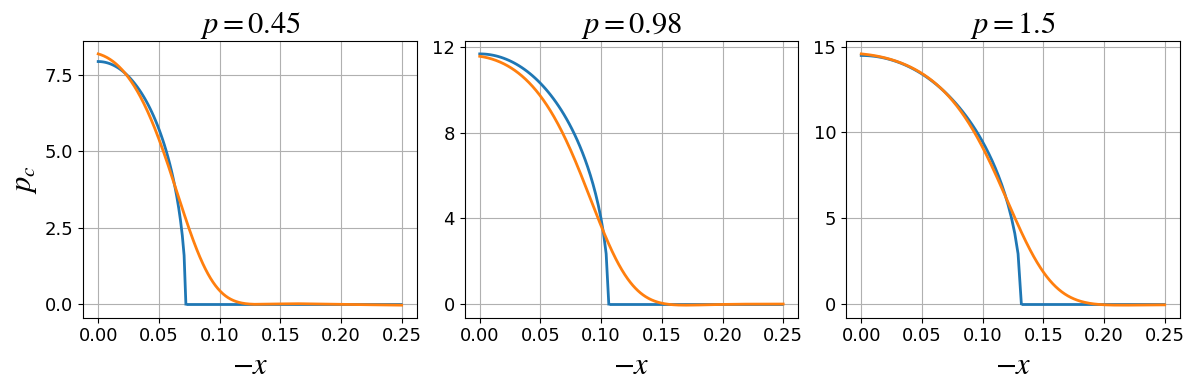

In [5]:
import numpy as np
import pandas as pd

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'

fig, ax = plt.subplots(1,external_dim_size,figsize=(external_dim_size*4,4))

lw = 2
s = 20
lines =[]
#titles=["(a)","(b)","(c)","(d)", "(e)"]
titles=[fr"$p={p_i[0]:1.2}$" for p_i in p]

for i in range(external_dim_size):
    ax[i].grid()
    
    l1, = ax[i].plot(x[i], pc[i], label="Analytical", lw=lw, zorder=2)
    
    ax[i].hlines(y=0, xmin=b[i], xmax=abs(x_lim), lw=lw, zorder=3)
    if scatter_plot:
        l3 = ax[i].scatter(-x_loc[i], pc_pred_list[i], color = "tab:orange", s=s, zorder=4)
    else:
        l3 = ax[i].plot(-x_loc[i], pc_pred_list[i], color = "tab:orange", lw=lw, zorder=4)

    # ax.legend(fontsize=20)
    #if case=="case_4":
    ax[i].set_xlabel(r"$-x$", fontsize=22)
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    
    
    #if case=="case_4":
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    # else:
    #     ax[i].tick_params(axis='y', which='both', labelsize=13)
        
    #     labels = [item.get_text() for item in ax[i].get_xticklabels()]

    #     empty_string_labels = ['']*len(labels)
    #     ax[i].set_xticklabels(empty_string_labels)
        
    ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].set_title(titles[i], size=22)

ax[0].set_ylabel(r"$p_c$", fontsize=22)

fig.subplots_adjust(bottom=0.3, wspace=0.175)

#plt.legend(handles = [l1,l3,l4,l5,l6] , labels=labels, loc='center', 
#              bbox_to_anchor=(-1.8, -0.35), fancybox=False, shadow=False, ncol=5, fontsize=15, handletextpad=0.5, handlelength=0.5)

plt.tight_layout()
#plt.savefig(f"{case}_{int(scatter_plot)}.png", dpi=300, bbox_inches='tight')

In [6]:
def abs_error(actual, pred):
    mape = np.mean(np.abs((actual - pred)/pred))
    return mape

def mse(actual, pred):
    return np.mean((actual-pred)**2)

def l2_norm(actual, pred):
    l2_error_stress = np.linalg.norm(actual - pred) / np.linalg.norm(actual)
    return l2_error_stress

for i in range(external_dim_size):
    
    x_e2 = -x_loc[i]
    pc_pred = pc_pred_list[i]
    pc_actual = 4*R*p[i]/(np.pi*b[i]**2)*np.sqrt(b[i]**2-x_e2**2)
    pc_actual[np.isnan(pc_actual)]=0
    
    l2_error = l2_norm(pc_actual.flatten(), pc_pred.flatten())
    print(f"Error for e2: {float(l2_error):.2%}")

Error for e2: 16.30%
Error for e2: 11.47%
Error for e2: 10.87%


/tmp/ipykernel_225943/859485890.py:16: RuntimeWarning: invalid value encountered in sqrt
  pc_actual = 4*R*p[i]/(np.pi*b[i]**2)*np.sqrt(b[i]**2-x_e2**2)
